___

**Classifying images into paracitized and unifected**

The dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells.

https://lhncbc.nlm.nih.gov/publication/pub9932

___

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

from sklearn.model_selection import train_test_split
from sklearn import metrics

import pandas as pd
from tqdm import notebook
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
sns.set_style('white')

# Reading the data

In [2]:
data_dir = r'./data/cell_images/'

In [3]:
os.listdir(data_dir)

['test', 'train']

In [4]:
test_path = data_dir+'/test/'
train_path = data_dir+'/train/'

In [5]:
os.listdir(test_path), os.listdir(train_path)

(['parasitized', 'uninfected'], ['parasitized', 'uninfected'])

In [6]:
all_parasitized = glob.glob(train_path+'/parasitized/*.png')
all_uninfected = glob.glob(train_path+'/uninfected/*.png')

## Plotting 25 randomly selected images

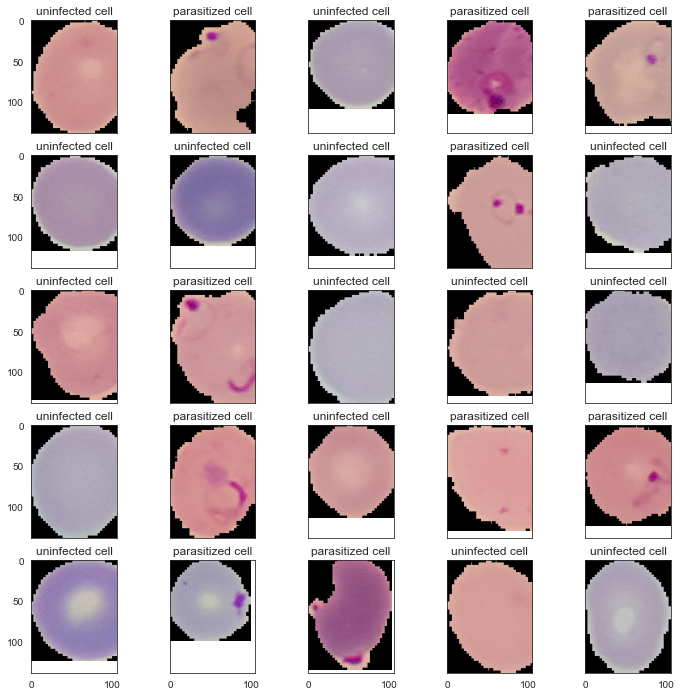

In [7]:
fig, axes = plt.subplots(5, 5, figsize=(12, 12), sharex=True, sharey=True)

for _, ax in enumerate(axes.flatten()):
    cat = np.random.choice(['parasitized', 'uninfected'])
    i = np.random.randint(0, len(all_parasitized))
    ax.imshow(imread(glob.glob(train_path+f'/{cat}/*')[i]))
    ax.set_title(f'{cat} cell')

Images seem to have varying dimensions

In [8]:
dims_uninfected = [(imread(img).shape[0], imread(img).shape[1]) for img in notebook.tqdm(all_uninfected)]
dims_parasitized = [(imread(img).shape[0], imread(img).shape[1]) for img in notebook.tqdm(all_parasitized)]

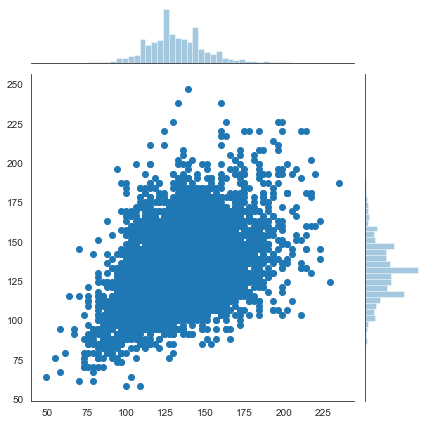

In [9]:
sns.jointplot([dim[0] for dim in dims_uninfected], [dim[1] for dim in dims_uninfected])
plt.show()

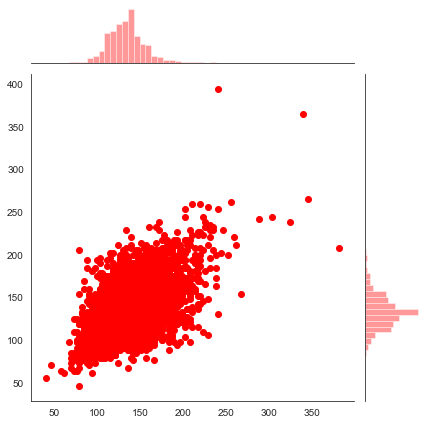

In [10]:
sns.jointplot([dim[0] for dim in dims_parasitized], [dim[1] for dim in dims_parasitized], color='r')
plt.show()

130 seems a good compromise to reshape the images for the CNN

In [11]:
image_shape = (130,130,3)

# Creating the generators

In [12]:
image_gen = ImageDataGenerator(rotation_range=20,  # Rotate the image 20 degrees
                               width_shift_range=0.10,  # Shift the pic width by a max of x%
                               height_shift_range=0.10,  # Shift the pic height by a max of x%
                               rescale=1/255, # Rescale the image by normalzing it
                               shear_range=0.1, # Cutting away part of the image (max 10%)
                               zoom_range=0.1,  # Zoom in by 10% max
                               horizontal_flip=True,  # Allo horizontal flipping
                               fill_mode='nearest'  # Fill in missing pixels with the nearest filled value
                               )

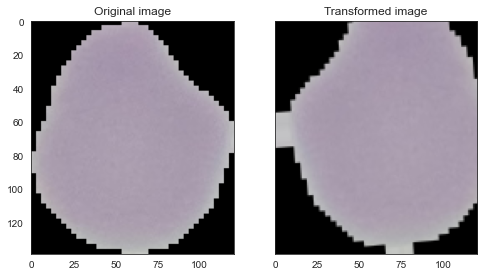

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8, 9), sharex=True, sharey=True)

cat = np.random.choice(['parasitized', 'uninfected'])
i = np.random.randint(0, len(all_parasitized))
axes.flatten()[0].imshow(imread(glob.glob(train_path+f'/{cat}/*')[i]))
axes.flatten()[0].set_title('Original image')
axes.flatten()[1].imshow(image_gen.random_transform(imread(glob.glob(train_path+f'/{cat}/*')[i])))
axes.flatten()[1].set_title('Transformed image')
plt.show()

In [14]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [15]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


## Define the model

In [16]:
with tf.device("/device:GPU:0"):
    model = Sequential()

    model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     input_shape=image_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64,
                     kernel_size=(3, 3),
                     input_shape=image_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64,
                     kernel_size=(3, 3),
                     input_shape=image_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))

    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        3

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [18]:
batch_size = 16
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='binary')
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary', shuffle=False)

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


## Train the model

In [19]:
with tf.device("/device:GPU:0"):
    results = model.fit(train_image_gen, epochs=30,
                        validation_data=test_image_gen,
                        callbacks=[early_stop])

Epoch 1/30
1560/1560 [==============================] - 88s 56ms/step - loss: 0.4012 - accuracy: 0.7987 - val_loss: 0.1947 - val_accuracy: 0.9296
Epoch 2/30
1560/1560 [==============================] - 87s 56ms/step - loss: 0.1847 - accuracy: 0.9431 - val_loss: 0.1776 - val_accuracy: 0.9408
Epoch 3/30
1560/1560 [==============================] - 88s 56ms/step - loss: 0.1707 - accuracy: 0.9474 - val_loss: 0.1746 - val_accuracy: 0.9438
Epoch 4/30
1560/1560 [==============================] - 88s 56ms/step - loss: 0.1639 - accuracy: 0.9493 - val_loss: 0.1806 - val_accuracy: 0.9377
Epoch 5/30
1560/1560 [==============================] - 88s 56ms/step - loss: 0.1611 - accuracy: 0.9486 - val_loss: 0.1470 - val_accuracy: 0.9519
Epoch 6/30
1560/1560 [==============================] - 87s 56ms/step - loss: 0.1602 - accuracy: 0.9509 - val_loss: 0.1515 - val_accuracy: 0.9465
Epoch 7/30
1560/1560 [==============================] - 87s 56ms/step - loss: 0.1560 - accuracy: 0.9505 - val_loss: 0.1537 -

In [25]:
model.save('malaria_detector.h5')

## Evaluating the model

In [23]:
model_perf = pd.DataFrame(model.history.history)

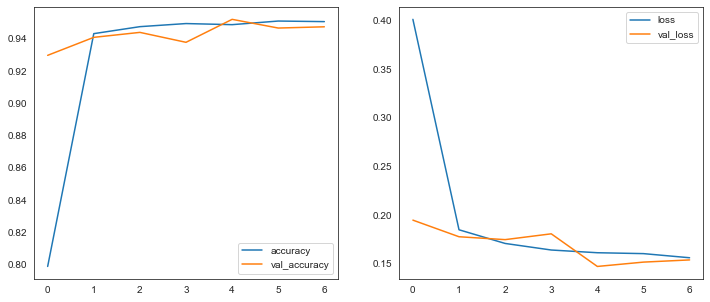

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

model_perf[['accuracy','val_accuracy']].plot(ax=axes[0])
model_perf[['loss','val_loss']].plot(ax=axes[1])

In [27]:
pred_probabilities = model.predict(test_image_gen)
predictions = pred_probabilities > 0.5

In [28]:
print(metrics.classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1300
           1       0.93      0.97      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



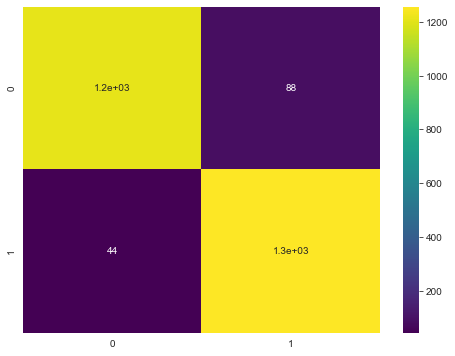

In [31]:
plt.figure(figsize=(8,6))
sns.heatmap(metrics.confusion_matrix(test_image_gen.classes,predictions), cmap='viridis',
           annot=True)

## Predict on a new image

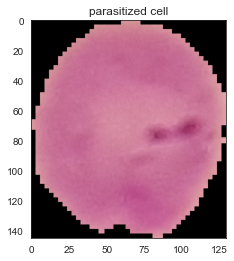

In [42]:
i = np.random.randint(0, len(all_parasitized))
cat = np.random.choice(['parasitized', 'uninfected'])
plt.imshow(imread(glob.glob(train_path+f'/{cat}/*')[i]))
plt.title(f'{cat} cell')
plt.show()

In [49]:
test_image = image.img_to_array(image.load_img(glob.glob(train_path+f'/{cat}/*')[i],target_size=image_shape))

In [50]:
test_image.shape

(130, 130, 3)

In [51]:
test_image = np.expand_dims(test_image, axis=0)

In [52]:
test_image.shape

(1, 130, 130, 3)

In [53]:
model.predict(test_image)

array([[0.]], dtype=float32)

In [54]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}